In [2]:
import time
from typing import List, Dict

import scipy.integrate
import autograd.numpy as np

import torch
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.datasets
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt

The first step was to model our Neural Network (NN), which gives the model $f(z(t), t, \theta)$ to how the hidden state changes. In the usual case of an usual, discrete NN, that change corresponds to the following update:

$$ \vec{z}_{t+1} = \vec{z}_t + f(\vec{z}(t), t, \theta)$$

However, using our ODE formulation, the dynamics of the hidden state becomes:

$$ \frac{d\vec{z}(t)}{dt} = f(\vec{z}(t), t, \theta)$$

In [3]:
#1d network to model
# i.e. we are defining dz(t)/dt = f(z(t), t, theta), f given in the nn below.

class SampleODE(nn.Module):
  def __init__(self):
      super(SampleODE, self).__init__()
      self.f = nn.Sequential(
          nn.Linear(1, 25),
          nn.ReLU(),
          nn.Linear(25, 1)
      )

  def forward(self, t, z):
    return self.f(z)

The second step was to solve the ODE. Here, a simple implemetation of the Euler method for integration was used to solve the differential equation in the form of $ \frac{d\vec{z}(t)}{dt} = f(\vec{z}(t), t, \theta)$. The Euler method can be written as:
$$\vec{z}_t = \vec{z}_{t-1} + h f(\vec{z}(t), t, \theta)$$

In [4]:
# solve the ODE:
# backwards pass, this should take the AUGMENTED Z, and have a function f to solve for such.
# forwards pass, take the normal dz(t)/dt = f(z(t), t, theta), find z values.

def ode_solve(z0, t0, t1, f):
  h = .5 # step size
  t = np.linspace(t0, t1, int((abs(t1 - t0))/h))
  z = z0
  for t in range(len(t)):
    z = z + h * f(t, z)
  return z



def adjoint_solve(atf, t0, t1, grad_f):
  # solve the ode backwards
  h = 0.05
  steps = int(abs(t1 - t0) / h)
  t = np.linspace(t0, t1, steps + 1)
  z = atf
  for i in range(1, len(t)):
    time = t[i]
    z = z + h * grad_f
  return z

Next, we defined the dynamics of the augmented state.

A few functions are utilized to describe how the augmented state evolves over time, starting with `grad_f`, the gradient of the function f (parameterized by the NN described previously) with respect to z, t and $\theta$.

In [5]:
def grad_f(z, t, p, a, module):
  '''
  Calculates the gradient of the function f with respect to z, t and p (parameters theta).

  ---
  Inputs:
    z: np.array
      Hidden state
    t: float
      Time
    p: ##type##
      Parameters, theta
    a: ##type##
      Adjoint, a
    module: function
      Function f
  ---
  Outputs:
    adfdz: ##type##
      Derivative of f wrt z
    adfdt: ##type##
      Derivative of f wrt t
    adfdp: ##type##
      Derivative of f wrt theta
    f: ##type##
      Function f evaluated at given z and t
  '''
  with torch.set_grad_enabled(True):
    # ensure that we can find gradients using autograd
    z.requires_grad_(True)
    t.requires_grad_(True)
    p.requires_grad_(True)

    # calculate output f; inputs are z, t
    f = module(z, t)
    # p = module.parameters() # in case we need the parameters after function calculation ?
    # torch autograd grad with grad_outputs computes jacobian product
    adfdz = torch.autograd.grad(f, z, grad_outputs=(a), allow_unused=True)
    adfdt = torch.autograd.grad(f, t, grad_outputs=(a), allow_unused=True)
    adfdp = torch.autograd.grad(f, p, grad_outputs=(a), allow_unused=True)

  return adfdz, adfdt, adfdp, f


The next function, `aug_dynamics`, is used to calculate how the augmented state $\vec{s}(t) = [\vec{z}(t), \vec{a}(t), \frac{\partial L}{\partial\theta}, \frac{\partial L}{\partial t}]$ evolves over time. In other words, it returns $\frac{d\vec{s}(t)}{dt}$.

In [6]:
def aug_dynamics(z, t, theta, a, module):
  '''
  Defines dynamics of augmented state.
  ---
  Inputs:
    z: np.array
      Hidden state
    t: float
      Time
    theta: ##type##
      Dynamic parameters
    a: ##type##
      Adjoint, a
    delL_deltheta: ##type##
      Derivative of loss wrt theta
    delL_delt: ##type##
      Derivative of loss wrt t
    module: function
      Function f

  ---

  Returns:
    delz_delt: np.array
      Time derivative of state, z

    dela_delt: ##[type]##
      Time derivative of adjoint, a

    deldelL_deltheta_delt: ##[type]##
      Time derivative of loss gradient wrt dynamic parameters, delL_deltheta

    delL_delt: ##[type]##
      Time derivative of loss, L

  '''
  # Build augmented state: [z, a, delL_deltheta, delL_delt]
  s = [z, a, _, _] # delL_deltheta and delL_delt are missing since we don't have them yet! But we won`t need them just yet

  # Calculate derivatives of f, as well as f itself (delz_delt)
  delf_delz, delf_delt, delf_deltheta, delz_delt = grad_f(z, t, theta, a, module)

  # Time derivative of adjoint
  dela_delt = -a.T@delf_delz # Vector-jacobian product

  # Time derivative of loss gradient
  deldelL_deltheta_delt = -a.T@delf_deltheta # Vector-jacobian product

  # Time derivative of loss
  delL_delt = -a.T@delf_delt # Vector-jacobian product

  return (delz_delt, dela_delt, deldelL_deltheta_delt, delL_delt)

Finally, function `gradient_loss`  calculates the gradients of the loss: $[\frac{\partial L}{\partial \vec{z}(t_0)}, \frac{\partial L}{\partial \theta}, \frac{\partial L}{\partial t_0}, \frac{\partial L}{\partial t_1}]$.

Function `ode_solve_augstate` is used to solve the augmented state dynamics.

In [7]:
def gradient_loss(theta, t0, t1, zt1, delL_delzt1, module):
  '''
  Reverse-mode derivative of an ODE initial value problem.
  Returns gradients of the loss.
  ---
  Inputs:
    theta: np.array
      Dynamic parameters

    t0: float
      Start time

    t1: float
      Stop time

    zt0:
      initial state

    zt1: np.array
      Final state

    delL_delzt1: ##[type]##
      Loss gradient at stop time

  ---

  Returns:
    delL_delzt0: ##[type]##
      Loss gradient at start time

    delL_deltheta: ##[type]##
      Loss gradient wrt dynamic parameters

    delL_delt0: ##[type]##
      Loss gradient wrt initial time

    delL_delt1: ##[type]##
      Loss gradient wrt stop time

  '''
  # Calculate f(z(t1), t1, theta)
  ft1 = module(zt1, t1, theta)

  # Calculate gradient of loss wrt t1
  delL_delt1 = delL_delzt1.T@ft1

  # Define initial augmented state
  s1 = np.array([zt1, delL_delzt1, np.zeros(theta.shape[0]), -delL_delt1]) #s1 = [zt1, delL_delzt1, delL_deltheta1, -delL_delt1]

  # Solve reverse-time ODE
  s0 = ode_solve_augstate(s1, t0, t1, aug_dynamics, zt1, theta, module)

  #s0 = [zt0, delL_delzt0, delL_deltheta0, -delL_delt0]
  zt0 = s0[0]
  delL_delzt0 = s0[1]
  delL_deltheta = s0[2]
  delL_delt0 = -s0[3]

  # Return gradients
  return delL_delzt0, delL_deltheta, delL_delt0, delL_delt1

In [8]:
def ode_solve_augstate(s1, t0, t1, dynamics, z, theta, module):
  '''Solves the ODE for the augmented state dynamics.'''

  # Initializing parameters
  h = .5 # step size
  t = np.linspace(t0, t1, int((abs(t1 - t0))/h))

  # Initial variables at t1
  s = s1 # start with s1
  a = s[1] #adjoint is the second element of s


  # Integrating for each timestep
  for t in range(len(t)):

    # Euler method
    s = s - h * dynamics(z, t, theta, a, module)

    #Update z and a
    z = s[0] #hidden state is the first element of s
    a = s[1] #adjoint is the second element of s

  return s1

In [9]:
## design a data loader
import torch
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [10]:
class NeuralODE(nn.Module):
    def __init__(self, module):
        super(NeuralODE, self).__init__()
        # our func should be a seperate nn.Module, with a forward func
        self.module = module

    def forward(self, z0, t):
        p = self.module.parameters()

        flat_p = []
        for params in p:
          flat_p.append(params.flatten())
        flat_p = torch.cat(flat_p)

        z = ODEForwardBackward.apply(z0, t, flat_p, self.module)
        return z[-2].view(-1, 1)

In [11]:
# we have to create a custom forward and backwards pass
# use torch.autograd.Function for this purpose

class ODEForwardBackward(torch.autograd.Function):
    @staticmethod
    def forward(ctx, z0, t, p, func):
      '''
      Finds the z values by solving the ODE
      ---
      Inputs:
        z0: initial state
        t: time vector
        p: parameters
        func: f(z(t), t, theta)
      ---
      Returns:
        z: filled z matrix
      '''
      # because we have our own backwards method, we do not need to track any gradients:
      # for now lets assume z is a vector, no batch
      t_len = t.size(0)
      z = torch.zeros(t_len, z0.size(0))
      z[0] = z0
      for i in range(t_len - 1):
        # func is a nn.Module. it should apply forward when calling func(--)
        res = ode_solve(z0, t[i], t[i+1], func)
        z[i] = res

      # save the function and t, z, p for backwards pass
      ctx.func = func
      ctx.save_for_backward(z.clone(), t, p)

      return z

    @staticmethod
    # pytorch AUTOMATICALLY gives us the loss gradient over the entire function.
    # therefore, from that gradient, we must return dldz0, dldt, and dldp
    # this is outlined in the appendix
    def backward(ctx, loss_grad):
      '''
      Finds our gradients wrt our inputs in forward pass
      ---
      Inputs:
        loss_grad: total loss gradient over z
      ---
      Returns:
        grad_z0: Loss gradient wrt z0
        grad_t: loss gradient wrt t
        grad_p: loss gradient wrt parameters
      '''

      #adjoint is dldz
      a = loss_grad

      # how can we get the gradients wrt our inputs?
      # dAaug/dt = -[a∂f/∂z, a∂f/∂θ, a∂f/∂t], integrate both sides

      # get our saved tensors
      func = ctx.func
      z, t, p = ctx.saved_tensors
      adfdz, adfdt, adfdp, out = grad_f(z, t, p, a, func)

      if adfdz[0] is None:
        adfdz = torch.zeros(z.size())
      if adfdt[0] is None:
        adfdt = torch.zeros(t.size())
      if adfdp[0] is None:
        adfdp = torch.zeros(p.size())

      # we can now solve for our gradients by using augmented dynamics
      # can we do it one by one too?
      for i in range(len(t) - 1, 1, -1):
        grad_z0 = adjoint_solve(a, t[i], t[i-1], -adfdz[-1])
        grad_t = adjoint_solve(t, t[i], t[i-1], -adfdt[-1])
        grad_p = adjoint_solve(p, t[i], t[i-1], -adfdp[-1])

      return grad_z0, grad_t, grad_p, None

In [12]:
# model evaluation
ODE = SampleODE()
model = NeuralODE(ODE)

# very simple problem
x = np.linspace(-4*np.pi, 4*np.pi, 300)
y = np.cos(x)

x_tensor = torch.tensor(x, dtype=torch.float32).view(-1, 1)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

dataset = TensorDataset(x_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# training
t = np.linspace(1, 10, num=10)
t_tensor = torch.tensor(t, dtype=torch.float32).view(-1, 1)

model.train()
epochs = 10
# for now, do batch size of 1, for simpler adjustments in ODE
for epoch in range(epochs):
  total_loss = 0
  for x_1, y_1 in dataloader:
    x_1 = torch.autograd.Variable(x_1, requires_grad=True)
    y_1 = torch.autograd.Variable(y_1, requires_grad=True)

    optimizer.zero_grad()
    y_pred = model(x_1, t_tensor)
    loss = criterion(y_pred, y_1)
    total_loss += loss.item()
    loss.backward()
    optimizer.step()
  average_loss = total_loss / len(x)
  print ("Epoch:", epoch, "Average Loss:", average_loss)

Epoch: 0 Average Loss: 53.47535101177016
Epoch: 1 Average Loss: 53.491649918898474
Epoch: 2 Average Loss: 53.491649918898474
Epoch: 3 Average Loss: 53.491649918898474
Epoch: 4 Average Loss: 53.49315237447076
Epoch: 5 Average Loss: 53.49165121366037
Epoch: 6 Average Loss: 53.49164991850111
Epoch: 7 Average Loss: 53.49273078452835
Epoch: 8 Average Loss: 53.49165003962427
Epoch: 9 Average Loss: 53.491650083506634


[3.0062125233598636e-07, 0.1282285749912262, 0.2564568519592285, 0.38468509912490845, 0.5129134654998779, 0.6411417126655579, 0.7693699598312378, 0.8975982666015625, 1.0258264541625977, 1.1540546417236328, 1.2822829484939575, 1.4105112552642822, 1.5387394428253174, 1.666967749595642, 1.7951960563659668, 1.9234243631362915, 2.0516529083251953, 2.1798810958862305, 2.3081092834472656, 2.43633770942688, 2.564565896987915, 2.69279408454895, 2.8210225105285645, 2.9492506980895996, 3.0774788856506348, 3.205707311630249, 3.333935499191284, 3.4621639251708984, 3.5903921127319336, 3.7186203002929688, 3.846848726272583, 3.975076913833618, 4.103304862976074, 4.231533050537109, 4.3597612380981445, 4.48798942565918, 4.616217613220215, 4.744446277618408, 4.872674465179443, 5.0009026527404785, 5.129130840301514, 5.257359027862549, 5.385587215423584, 5.513815879821777, 5.6420440673828125, 5.770272254943848, 5.898500442504883, 6.026728630065918, 6.154956817626953, 6.2831854820251465]


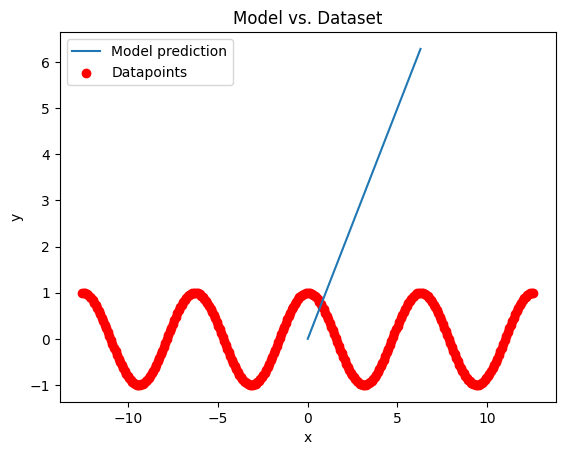

In [13]:
x_test = np.linspace(0*np.pi, 2*np.pi, 50)
y_test = np.cos(x_test)

testset = TensorDataset(torch.tensor(x_test, dtype=torch.float32).view(-1, 1), torch.tensor(y_test, dtype=torch.float32).view(-1, 1))
testloader = DataLoader(testset, batch_size=1)


model.eval()

out = []
for x_1, y_1 in testloader:
  x_1 = torch.autograd.Variable(x_1, requires_grad=True)
  y_1 = torch.autograd.Variable(y_1, requires_grad=True)

  y_pred = model(x_1, t_tensor).item()

  out.append(y_pred)

print(out)

plt.plot(x_test, out, label='Model prediction')
plt.scatter(x, y, c='red', label='Datapoints')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Model vs. Dataset')
plt.legend()
plt.show()